# Morsy
## Speckel 1 vs 2
### 6/24/20

# a. Speckel 1

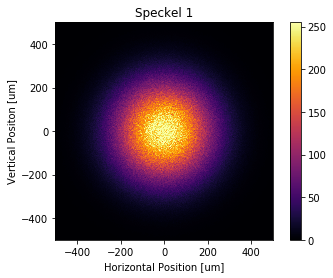

In [1]:
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
spk_1 = Image.open('C:\\Users\\User\\Downloads\\speckle_one.png', "r" ) # Enter the directory of the speckle pic

%matplotlib inline
# ploting the speckle pic with a pixle scale (1 um meter) axis

dx_m = 1*10**-6  #pixel size in meter
Dx_m = 1e-3      #image full size

extent = (-Dx_m/2 * 1e6, +Dx_m/2 * 1e6, -Dx_m/2 * 1e6, +Dx_m/2 * 1e6) # Setting up axis scale and origin

plt.imshow(spk_1, extent = extent, cmap = 'inferno')
plt.xlabel('Horizontal Position [um]')
plt.ylabel('Vertical Positon [um]')
plt.title('Speckel 1')
plt.colorbar()
plt.show()

In [2]:
x_m = np.linspace(-Dx_m/2, Dx_m/2, Dx_m/dx_m + 1)
real_axis = x_m
fs = 1/(real_axis[1]-real_axis[0]) # Setting the unit of the frequncy scale to 1/um (when i do the calculations i get 1/mm)
Nfft=len(real_axis)
            
df = fs/Nfft
f_cpm = np.linspace(0,(fs-df),Nfft) - (fs-np.mod(Nfft,2)*df)/2 # Do not understand the calculations here.

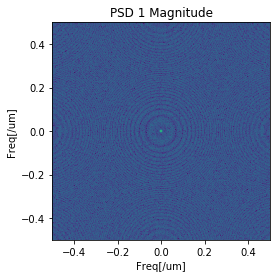

In [3]:
%matplotlib inline
data_1 = np.asarray(spk_1) # Converts the image into a numpy array
Y1 = np.fft.fftshift(np.fft.fft2(data_1))  # it rearranges the fourier transform to make it symetrical about zero

df_cpm = f_cpm[1] - f_cpm[0]  #pixel size in meter
Df_cpm = f_cpm[-1] - f_cpm[0]      #image full size
extent = (-Df_cpm/2 * 1e-6, +Df_cpm/2 * 1e-6, -Df_cpm/2 * 1e-6, +Df_cpm/2 * 1e-6) 

plt.imshow(np.abs(Y1)**0.1, extent = extent)
plt.xlabel('Freq[/um]')
plt.ylabel('Freq[/um]')
plt.title('PSD 1 Magnitude')
plt.show()

In [4]:
np.shape(np.linspace(0,(fs-df),Nfft))
np.shape(f_cpm)

(1001,)

## Creating a circle on the Image

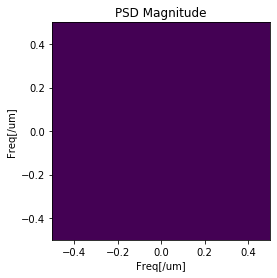

In [5]:
(Fx, Fy) = np.meshgrid(f_cpm, f_cpm)
Z = Fx**2 + Fy**2    # Equation of a circule
r = df_cpm * 100      # Radious of the ring
dr = df_cpm * 1     # Thikness of the ring
#a = np.where(Z >= 10)
#a = np.where(np.abs(Z - 10) < 1) 
a = np.where(np.abs(Z - r**2) < dr**2)   # Creates an array that contained zeros everywhere exept for the radii
A = Z * 0
A[a] = 1


plt.imshow(A, extent = extent)
plt.xlabel('Freq[/um]')
plt.ylabel('Freq[/um]')
plt.title('PSD Magnitude')
plt.show()

In [6]:
temp_1 = np.abs(Y1) * A
intg_1 = np.sum(temp_1)
intg_1

14205.16410053787

In [7]:
#N = np.size(f_cpm)/2
N = 501
circ_sum_1 = np.zeros(N)
for i in np.arange(N):
    r = df_cpm * i      # Radious of the ring
    dr = df_cpm     # Thikness of the ring
    #a = np.where(np.abs(Z - r**2) <= dr**2)   # Creates an array that contained zeros everywhere exept for the radii
    a = np.where((Z >= r**2) & (Z < (r + dr)**2))
    A = Z * 0
    A[a] = 1
    
    circ_sum_1[i] = np.sum(np.abs(Y1) * A) / np.sum(A)
    temp_1 = np.sum(np.abs(Y1) *A)

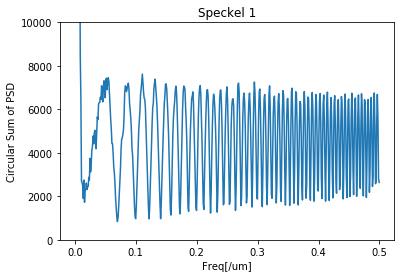

In [8]:
plt.plot(f_cpm[500:] * 1e-6, circ_sum_1)
plt.ylim((0, 10000))
plt.title('Speckel 1')
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
plt.show()

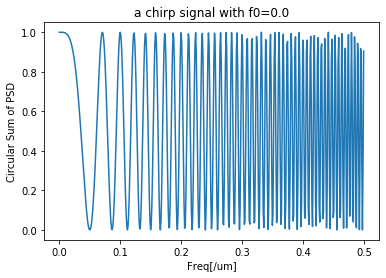

In [9]:
# Chirp model:

x = f_cpm[500:] # Setting the frequency scale axis of the chirp to match that of the signal.
chirp = lambda mod_freq: abs(np.cos(2*np.pi*mod_freq*x**2))**2 # Equation of chirp, which is used here to fit the signal!

mod_freq = 0.01 * 1e-8 # Chirp frequency

plt.plot(f_cpm[500:] * 1e-6,chirp(mod_freq))
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
plt.title('a chirp signal with f0=%1.1f' %mod_freq)
plt.show() 

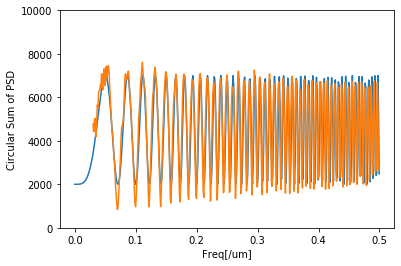

In [10]:
x = f_cpm[500:]
chirp = lambda mod_freq, a, b: a * abs(np.sin(2*np.pi*mod_freq*x**2))**2 + b

mod_freq = 0.01 * 1e-8 # Chirp frequency

a = 5000 # Chirp amplitude
b= 2000  # Chirp offset

plt.plot(f_cpm[500:] * 1e-6, chirp(mod_freq, a, b), f_cpm[530:] * 1e-6, circ_sum_1[30:])
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
#plt.title('a chirp signal with f0=%1.1f' %f0)
#plt.xlim((0, x[-1]))
plt.ylim((0,10000))
plt.show()

625552064.1366777
Optimization terminated successfully.
         Current function value: 82017375.738722
         Iterations: 106
         Function evaluations: 202


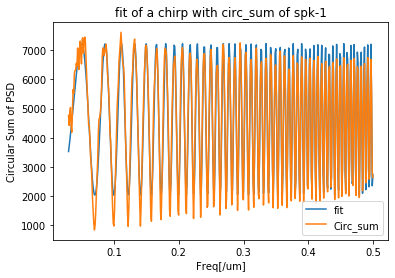

In [11]:
# Fitting Chirp to Circular sum
import scipy.optimize

chirp_opt = lambda X: X[1] * abs(np.sin(2*np.pi*X[0]*f_cpm[530:]**2))**2 + X[2]

cost_func = lambda X: np.sum(np.abs(circ_sum_1[30:] - chirp_opt(X))**2)
X0 = [mod_freq, a, b]
print(cost_func(X0))

xopt = scipy.optimize.fmin(cost_func, x0=X0)

plt.plot(f_cpm[530:] * 1e-6, chirp_opt(xopt), f_cpm[530:] * 1e-6, circ_sum_1[30:])
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
plt.title('fit of a chirp with circ_sum of spk-1')
plt.legend(('fit', 'Circ_sum'))
plt.show()


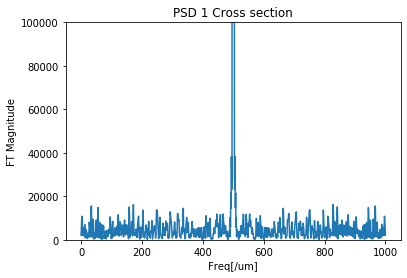

In [12]:
%matplotlib inline
(width, height) = data_1.shape
data_cross_x1 = np.abs(Y1[:, int(np.floor(height/2))])
plt.plot(data_cross_x1)
plt.title('PSD 1 Cross section')
plt.xlabel('Freq[/um]')
plt.ylabel('FT Magnitude')
plt.ylim((0, .1e6))
plt.show()

In [13]:
# finding the phase at the fundemental freq:
x_m = np.linspace(-Dx_m/2, Dx_m/2, Dx_m/dx_m + 1)

f0 = f_cpm[500:] * 1e-6 # The frequency
y_1 = circ_sum_1 # PSD 1 Curvefitted

idx_1 = np.where(f_cpm >= f0)[0][0]-1
Y_1 = np.fft.fft(y_1) # this creat a fourier transformation of "y" and assign it a new variable "Y"
Yc_1 = np.fft.fftshift(Y_1)
np.angle(Yc[idx])

ValueError: operands could not be broadcast together with shapes (1001,) (501,) 

# b. Speckel 2:

In [ ]:
spk_2 = Image.open("C:\\Users\\User\\Downloads\\speckle_two.png", "r" )

%matplotlib inline
plt.imshow(spk_2, extent = extent)
plt.xlabel('Horizontal Position [um]')
plt.ylabel('Vertical Positon [um]')
plt.title('speckle 2')
plt.show()

In [ ]:
%matplotlib inline
data_2 = np.asarray(spk_2) # Converts the image into a numpy array
Y2 = np.fft.fftshift(np.fft.fft2(data_2))  # it rearranges the fourier transform to make it symetrical about zero

df_cpm = f_cpm[1] - f_cpm[0]  #pixel size in meter
Df_cpm = f_cpm[-1] - f_cpm[0]      #image full size
extent = (-Df_cpm/2 * 1e-6, +Df_cpm/2 * 1e-6, -Df_cpm/2 * 1e-6, +Df_cpm/2 * 1e-6) 

plt.imshow(np.abs(Y2)**0.1, extent = extent)
plt.xlabel('Freq[/um]')
plt.ylabel('Freq[/um]')
plt.title('PSD 2 Magnitude')
plt.show()

In [ ]:
circ_sum_2 = np.zeros(N)
for i in np.arange(N):
    r = df_cpm * i      # Radious of the ring
    dr = df_cpm     # Thikness of the ring
    #a = np.where(np.abs(Z - r**2) <= dr**2)   # Creates an array that contained zeros everywhere exept for the radii
    a = np.where((Z >= r**2) & (Z < (r + dr)**2))
    A = Z * 0
    A[a] = 1
    
    circ_sum_2[i] = np.sum(np.abs(Y2) * A) / np.sum(A)

In [ ]:
plt.plot(f_cpm[500:] * 1e-6, circ_sum_2)
plt.ylim((0, 10000))
plt.title('Spekle 2')
plt.xlabel('Frequency [/um]')
plt.ylabel('Circular Sum of PSD')
plt.show()

In [ ]:
# Fitting Chirp to Circ_sum_2
idx = 1000
chirp_opt2 = lambda X: X[1] * abs(np.sin(2*np.pi*X[0]*f_cpm[530:idx]**2))**2 + X[2]

cost_func2 = lambda X: np.sum(np.abs(circ_sum_2[30:idx-500] - chirp_opt2(X))**2)

a2_m2 = 0.015 * 1e-8 # Chirp frequency
a2 = 6000 # Chirp amplitude
b2= 1500  # Chirp offset
X02 = [a2_m2, a2, b2]

plt.plot(f_cpm[530:idx] * 1e-6, chirp_opt2(X02), f_cpm[530:idx] * 1e-6, circ_sum_2[30:idx - 500])
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
plt.title('chirp fitted to circ_sum_2')
#plt.xlim((0, x[-1]))
plt.ylim((0,10000))
plt.show()

In [ ]:
# Fitting Chirp to Circ_sum_2
X02 = [a2_m2, a2, b2]
print(cost_func2(X0))

xopt_2 = scipy.optimize.fmin(cost_func2, x0=X02)


plt.plot(f_cpm[530:idx] * 1e-6, chirp_opt2(xopt_2), f_cpm[530:idx] * 1e-6, circ_sum_2[30:idx - 500])
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
plt.title('fit of a chirp with circ_sum of spk-1')
plt.legend(('fit', 'noisy data'))
plt.show()


In [ ]:
print(" %1.16f"% (xopt_2[0] * 1e12) + ' [um^2]')
print(" %1.16f"% (xopt[0] * 1e12) + ' [um^2]')

In [ ]:
Displace_meas = (1/(xopt[0]/xopt_2[0]))
print('Displacement = ' + str(Displace_meas) + ' mm')

In [ ]:
precision_nm = (1/(xopt[0]/xopt_2[0]) - 1.5) * 1e6
print('precision = '+ str(precision_nm) + ' nm')

In [ ]:
plt.plot(f_cpm[500:] * 1e-6, circ_sum_1, f_cpm[500:] * 1e-6, circ_sum_2)
plt.ylim((0, 10000))
plt.title('Speckle Sum Comparisson')
plt.legend(('Speckle 1', 'Speckle 2'))
plt.xlabel('Frequency [/um]')
plt.ylabel('Circular Sum of PSD')
plt.show()

In [ ]:
%matplotlib inline
(width, height) = data_2.shape
data_cross_x2 = np.abs(Y2[:, int(np.floor(height/2))])
plt.plot(data_cross_x2)
plt.title('PSD 2 Cross section')
plt.ylim((0, .1e6))
plt.show()

In [ ]:
# finding the phase at the fundemental freq:

x_s = np.linspace(0,10,1001) # define the x-axis as an array
f0 = 1 # giving a value for the frequency
y = np.cos(2*np.pi*f0*x_s+ 1) #adding a phase shift that corresponds to the element 510 in f_cpm array
idx = np.where(f_cpm >= f0)[0][0]-1
Y = np.fft.fft(y) # this creat a fourier transformation of "y" and assign it a new variable "Y"
Yc = np.fft.fftshift(Y)
np.angle(Yc[idx])

# Data fitting 

In [ ]:
import scipy.optimize
data = f_cpm[500:] * 1e-6, circ_sum_2 #put an array of data here
chirp = lambda f: abs(sin(2*pi*f*x**2))
cost_function = lambda f: np.abs(data-chirp(f))**2
xopt = scipy.optimize.fmin((func=cost_function), f0=[1])
print(xopt)
